In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import seaborn as sns
import RELACS as rel
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [1]:
%%bash

### create consensus of all peaks of mESC and NPC48h

cat ../INPUT_DATA/NPC48h_H3K27ac_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K27ac_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K4me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K4me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K4me1_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K4me1_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K79me2_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K79me2_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K27me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K27me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K36me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K36me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/NPC48h_H3K9me3_BAMPE-BAM_consensusPeaks.bed \
../INPUT_DATA/mESC_H3K9me3_BAMPE-BAM_consensusPeaks.bed | bedtools sort | \
bedtools merge -d 5000 | awk -v OFS="\t" '{a+=1; print $0,"peakRegion_"a, $3-$2}' > ../INTERMEDIATE_FILES/EnrichedRegions_allMarks.bed

In [4]:
bins_min = 500
bins=2000
regions = pd.read_csv("../INTERMEDIATE_FILES/EnrichedRegions_allMarks.bed", sep="\t", header=None, names=["chr","start","end","peak_ID","len"])
regions_500 = regions.loc[(regions.end.values - regions.start.values)>bins_min]
regions_500["length"] = regions_500.end.values - regions_500.start.values
regions_500["to_add"] = np.ceil((bins - (regions_500.length.values % bins)) / 2)
regions_500["start"] = (regions_500.start - regions_500.to_add).astype(int)
regions_500["end"] = (regions_500.end + regions_500.to_add).astype(int)
regions_500["length"] = regions_500.end.values - regions_500.start.values
regions_500["end"] = [regions_500["end"].values[i] if regions_500["length"].values[i]%bins == 0 else regions_500["end"].values[i]-1 for i in range(len(regions_500["end"].values))]
regions_500["length"] = regions_500.end.values - regions_500.start.values

regions_500[["chr","start","end","peak_ID"]].to_csv("../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed.bed", sep="\t", header=False, index=False)
regions_500.head()

/package/anaconda3/bin/ipython:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/package/anaconda3/bin/ipython:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sys.exit(IPython.start_ipython())
/package/anaconda3/bin/ipython:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

,chr,start,end,peak_ID,len,length,to_add
0,1,3030703,3034703,peakRegion_1,2081,4000,960.0
1,1,3041906,3043906,peakRegion_2,729,2000,636.0
2,1,3051186,3057186,peakRegion_3,5172,6000,414.0
3,1,3061150,3071150,peakRegion_4,8707,10000,647.0
4,1,3141888,3157888,peakRegion_5,14833,16000,584.0


In [5]:
keep = [str(i) for i in list(range(1,20))] + ["X","Y"]
with open("../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed.bed") as inp, open("../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed", "w") as out:
    p=0
    for line in inp:
        lista=line.strip().split()
        if lista[0] in keep:
            times = int((int(lista[2]) - int(lista[1])) / bins )
            start = int(lista[1])
            for k in range(times):
                p+=1
                out.write("\t".join([lista[0], str(int(start)), str(int(start+bins)), "bin_{}\n".format(p)]))
                start = start+bins
            
#         times = int((int(lista[2]) - int(lista[1])) / bins ) - 1 
#         start = int(lista[1]) + (bins/2)
#         if times == 0:
#             times = 1
#             start = int(lista[1])

In [21]:
%%bash

multiBamSummary BED-file -b ../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K27ac_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K27me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K36me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K4me1_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K4me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K79me2_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K9me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_Input.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K27ac_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K27me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K36me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K4me1_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K4me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K79me2_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K9me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_Input.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K27me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K4me1_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K4me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K79me2_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K9me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_Input.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K27me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K36me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K4me1_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K4me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K79me2_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K9me3_merged.filtered.bam \
../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_Input.filtered.bam \
-o ../INTERMEDIATE_FILES/counts_DMSO_mESC_NPC48h_allMarks.mat.gz --outRawCounts ../INTERMEDIATE_FILES/counts_DMSO_mESC_NPC48h_allMarks.counts \
--BED ../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed -bl /home/ferrari/ferrari/my_repository/blacklist_ChIP-Seq/GRCm38_General_readAttractingRegions.UseThisOne_DKFZ.bed \
-p 20 -e --minMappingQuality 3

Number of bins found: 250988


In [6]:
keep = [str(i) for i in list(range(1,20))] + ["X","Y"]
counts = pd.read_csv("../INTERMEDIATE_FILES/counts_DMSO_mESC_NPC48h_allMarks.counts", sep="\t")

counts_ref = rel.preprocess_deeptools(counts, merge_rep=True, list_of_columns=[[0],[8],[1],[9],[2],[10],[3],[11],[4],[12],[5],[13],[6],[14],
                                                                               [16],[24],[17],[25],[18],[26],[19],[27],[20],[28],[21],[29],[22],[30]])
counts_log = rel.preprocess_deeptools(counts, log=True)

counts_keep = [str(i.split("_")[0]) in keep for i in counts_ref.index]
counts_ref=counts_ref.loc[counts_keep]

counts_ref

,'mESC_DMSO_rep1_H3K27ac_merged.filtered.bam','mESC_DMSO_rep2_H3K27ac_merged.filtered.bam','mESC_DMSO_rep1_H3K27me3_merged.filtered.bam','mESC_DMSO_rep2_H3K27me3_merged.filtered.bam','mESC_DMSO_rep1_H3K36me3_merged.filtered.bam','mESC_DMSO_rep2_H3K36me3_merged.filtered.bam','mESC_DMSO_rep1_H3K4me1_merged.filtered.bam','mESC_DMSO_rep2_H3K4me1_merged.filtered.bam','mESC_DMSO_rep1_H3K4me3_merged.filtered.bam','mESC_DMSO_rep2_H3K4me3_merged.filtered.bam',...,'iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam','iNPC_DMSO_rep2_H3K36me3_merged.filtered.bam','iNPC_DMSO_rep1_H3K4me1_merged.filtered.bam','iNPC_DMSO_rep2_H3K4me1_merged.filtered.bam','iNPC_DMSO_rep1_H3K4me3_merged.filtered.bam','iNPC_DMSO_rep2_H3K4me3_merged.filtered.bam','iNPC_DMSO_rep1_H3K79me2_merged.filtered.bam','iNPC_DMSO_rep2_H3K79me2_merged.filtered.bam','iNPC_DMSO_rep1_H3K9me3_merged.filtered.bam','iNPC_DMSO_rep2_H3K9me3_merged.filtered.bam'
7_96146570_96148570,64,60,73,71,83,32,78,68,96,29,...,25,22,6,21,6,25,13,53,30,34
7_96148570_96150570,81,68,90,99,67,52,69,91,78,16,...,18,27,13,17,5,43,11,53,28,12
7_96150570_96152570,198,265,110,79,83,68,127,169,95,48,...,18,44,14,16,15,26,27,59,12,34
7_96152570_96154570,286,414,70,85,109,59,125,142,119,91,...,27,39,38,37,14,26,32,62,17,13
7_96154570_96156570,40,104,35,59,54,18,46,32,51,23,...,15,27,11,14,4,15,22,43,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_173081577_173083577,130,197,62,64,86,51,98,69,79,40,...,14,18,9,14,9,27,10,28,12,21
2_173083577_173085577,222,331,62,71,91,68,100,116,123,65,...,16,22,12,15,9,9,20,17,6,15
15_28607637_28609637,30,27,59,64,48,11,12,5,15,19,...,13,24,20,30,4,8,27,59,29,18
11_45641926_45643926,58,20,56,58,70,19,52,24,55,26,...,15,39,13,46,23,31,21,31,18,33


In [7]:
%%R -i counts_ref -o counts_vst

lib_ = "/home/ferrari/R/x86_64-redhat-linux-gnu-library/3.5"

library(DESeq2, lib = lib_)
library(rtracklayer, lib = lib_)

### IMPORT COUNTS ###
count=counts_ref

# ### CREATE DESIGN TABLE ###
design_table=data.frame(row.names = colnames(count),
                        condition = c(rep("mESC",14),rep("NPC48h",14)))

# ### CREATE DDS OBJECT ###
dds = DESeqDataSetFromMatrix(countData = count,
                              colData = design_table,
                              design = ~ condition)

# ### PREFILTERING ###
keep = rowSums(counts(dds)) >= 10
dds = dds[keep,]

# ### CREATE VST TRANSFORMATION OF COUNT DATA ### 
vst = vst(dds)
counts_vst = as.data.frame(assay(vst))

/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘pac

In [8]:
### SELECT TOP 500 MOST VARIABLE BINS IN VST MATIRX FOR EACH MARK ###

marks = ["H3K4me3","H3K4me1","H3K27ac","H3K36me3","H3K79me2","H3K9me3","H3K27me3"]

dfs = []
for i in marks:
    df = counts_vst.filter(regex = ".*{}.*".format(i), axis=1)
    highvar = list(df.var(axis=1).sort_values(ascending=False).index)[:500]
    df = df.loc[highvar]
    df.columns = ["mESC_1","mESC_2","NPC48h_1","NPC48h_2"]
    dfs.append(df)

final_df = pd.concat(dfs, axis=0, ignore_index=True)

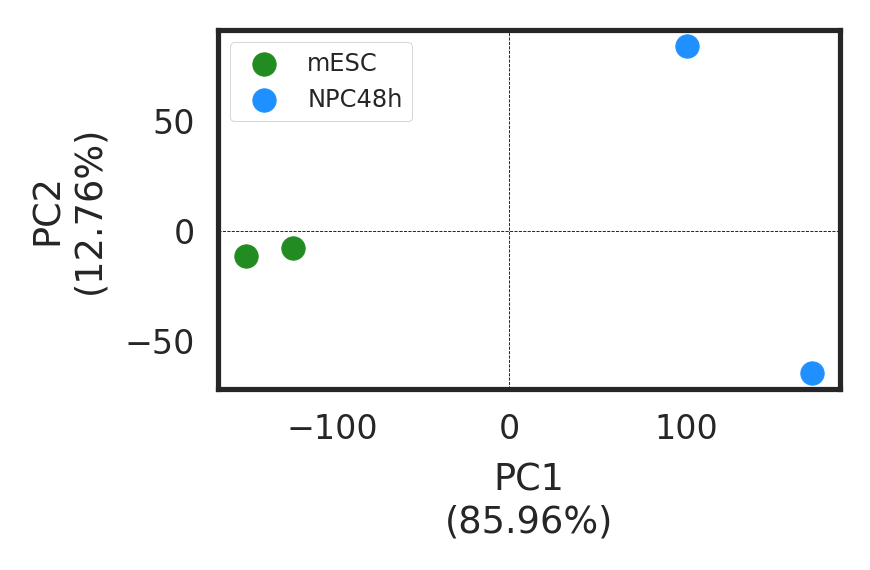

In [10]:
### PERFORM PCA ###
pca = PCA()
pca_data = pca.fit_transform(final_df.T)

labels = ["PC{}".format(i) for i in range(pca_data.shape[1]+1)[1:]]
pca_df = pd.DataFrame(pca_data, index = ["mESC_1","mESC_2","NPC48h_1","NPC48h_2"], columns=labels)


### PLOT PCA ###
fig,ax=plt.subplots(dpi=300, figsize=(3,2))

plt.scatter(pca_df.filter(regex="^mESC", axis=0)["PC1"], pca_df.filter(regex="^mESC", axis=0)["PC2"], color="forestgreen", label = "mESC")
plt.scatter(pca_df.filter(regex="^NPC", axis=0)["PC1"], pca_df.filter(regex="^NPC", axis=0)["PC2"], color="dodgerblue", label = "NPC48h")

ax.set_xlabel("PC1\n({}%)".format(round(pca.explained_variance_ratio_[0]*100,2)))
ax.set_ylabel("PC2\n({}%)".format(round(pca.explained_variance_ratio_[1]*100,2)))

# ax.set_ylim(-10,13)
# ax.set_xlim(-120,120)

plt.axhline(0,linestyle="--",linewidth=0.2, color="k")
plt.axvline(0,linestyle="--",linewidth=0.2, color="k")

plt.legend(fontsize='xx-small', frameon=True)

plt.tight_layout()

plt.savefig("../FIGURES/PCA_EPIGENOME_mESC_NPC48h.pdf")

In [33]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K4me3 #

pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K4me3_NPCvsESC.txt ../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed ../INTERMEDIATE_FILES/DIFF_H3K4me3

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K4me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K4me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K4me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K4me3_merged.filtered.bam
mark: H3K4me3
outdir: ../DATA/DIFF_H3K4me3
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null device 
       

Number of bins found: 250743
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    uns

In [34]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K4me1 #

pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K4me1_NPCvsESC.txt ../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed ../INTERMEDIATE_FILES/DIFF_H3K4me1

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K4me1_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K4me1_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K4me1_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K4me1_merged.filtered.bam
mark: H3K4me1
outdir: ../DATA/DIFF_H3K4me1
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null device 
       

Number of bins found: 250743
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    uns

In [35]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K27ac #

pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K27ac_NPCvsESC.txt ../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed ../INTERMEDIATE_FILES/DIFF_H3K27ac

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K27ac_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K27ac_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam
mark: H3K27ac
outdir: ../DATA/DIFF_H3K27ac
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null device 
       

Number of bins found: 250743
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    uns

In [36]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K27me3 #

pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K27me3_NPCvsESC.txt ../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed ../INTERMEDIATE_FILES/DIFF_H3K27me3

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K27me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K27me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K27me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K27me3_merged.filtered.bam
mark: H3K27me3
outdir: ../DATA/DIFF_H3K27me3
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null device 
 

Number of bins found: 250743
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    uns

In [37]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K36me3 #

pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K36me3_NPCvsESC.txt ../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed ../INTERMEDIATE_FILES/DIFF_H3K36me3

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K36me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K36me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K36me3_merged.filtered.bam
mark: H3K36me3
outdir: ../DATA/DIFF_H3K36me3
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null device 
 

Number of bins found: 250743
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    uns

In [38]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K9me3 #

pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K9me3_NPCvsESC.txt ../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed ../INTERMEDIATE_FILES/DIFF_H3K9me3

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K9me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K9me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K9me3_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K9me3_merged.filtered.bam
mark: H3K9me3
outdir: ../DATA/DIFF_H3K9me3
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null device 
       

Number of bins found: 250743
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    uns

In [39]:
%%bash

### PERFORM DESEQ2 DIFFERENTIAL ANALYSIS FOR EACH MARK ###
# H3K79me2 #

pipe_DiffPeaks.sh ../INPUT_DATA/info_data_H3K79me2_NPCvsESC.txt ../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed ../INTERMEDIATE_FILES/DIFF_H3K79me2

bams: /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep1_H3K79me2_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_DMSO_rep2_H3K79me2_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep1_H3K79me2_merged.filtered.bam /data/manke/group/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_DMSO_rep2_H3K79me2_merged.filtered.bam
mark: H3K79me2
outdir: ../DATA/DIFF_H3K79me2
[1] TRUE
null device 
          1 
null device 
          1 
null device 
          1 
[1] "Intercept"               "condition_NPC48_vs_mESC"
null device 
 

Number of bins found: 250743
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    uns

# PLOTTING

In [11]:
### load files

loci = pd.read_csv("../INTERMEDIATE_FILES/EnrichedRegions_allMarks_normed_binned.bed",sep="\t", header=None, names=["chr","start","end","locus_ID"])

annot = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K27ac/output_uropa/peaks_Annotation_finalhits.bed",sep="\t", header=None)



/home/ferrari/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
h3k4me3 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K4me3/resLFC_apeglm.tsv",sep="\t",index_col=0)
h3k4me3.columns = ["baseMean_H3K4me3","log2FoldChange_H3K4me3","lfcSE","pvalue","padj_H3K4me3"]
h3k4me3 = h3k4me3[["log2FoldChange_H3K4me3"]]
h3k4me3

h3k4me1 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K4me1/resLFC_apeglm.tsv",sep="\t",index_col=0)
h3k4me1.columns = ["baseMean_H3K4me1","log2FoldChange_H3K4me1","lfcSE","pvalue","padj_H3K4me1"]
h3k4me1 = h3k4me1[["log2FoldChange_H3K4me1"]]
h3k4me1

m1 = h3k4me3.merge(h3k4me1, how="left", right_index=True, left_index=True)
m1

h3k27ac = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K27ac/resLFC_apeglm.tsv",sep="\t",index_col=0)
h3k27ac.columns = ["baseMean_H3K27ac","log2FoldChange_H3K27ac","lfcSE","pvalue","padj_H3K27ac"]
h3k27ac = h3k27ac[["log2FoldChange_H3K27ac"]]
h3k27ac

m2 = m1.merge(h3k27ac, how="left", right_index=True, left_index=True)
m2

h3k27me3 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K27me3/resLFC_apeglm.tsv",sep="\t",index_col=0)
h3k27me3.columns = ["baseMean_H3K27me3","log2FoldChange_H3K27me3","lfcSE","pvalue","padj_H3K27me3"]
h3k27me3 = h3k27me3[["log2FoldChange_H3K27me3"]]
h3k27me3

m3 = m2.merge(h3k27me3, how="left", right_index=True, left_index=True)
m3

h3k36me3 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K36me3/resLFC_apeglm.tsv",sep="\t",index_col=0)
h3k36me3.columns = ["baseMean_H3K36me3","log2FoldChange_H3K36me3","lfcSE","pvalue","padj_H3K36me3"]
h3k36me3 = h3k36me3[["log2FoldChange_H3K36me3"]]
h3k36me3

m4 = m3.merge(h3k36me3, how="left", right_index=True, left_index=True)

h3k9me3 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K9me3/resLFC_apeglm.tsv",sep="\t",index_col=0)
h3k9me3.columns = ["baseMean_H3K9me3","log2FoldChange_H3K9me3","lfcSE","pvalue","padj_H3K9me3"]
h3k9me3 = h3k9me3[["log2FoldChange_H3K9me3"]]
h3k9me3

m5 = m4.merge(h3k9me3, how="left", right_index=True, left_index=True)

h3k79me2 = pd.read_csv("../INTERMEDIATE_FILES/DIFF_H3K79me2/resLFC_apeglm.tsv",sep="\t",index_col=0)
h3k79me2.columns = ["baseMean_H3K79me2","log2FoldChange_H3K79me2","lfcSE","pvalue","padj_H3K79me2"]
h3k79me2 = h3k79me2[["log2FoldChange_H3K79me2"]]
h3k79me2

m6 = m5.merge(h3k79me2, how="left", right_index=True, left_index=True)
m6["abs_mean_LFC"] = np.fabs(m6).mean(axis=1)
m6["mean_LFC"] = m6.mean(axis=1)
m6

m6_annot = m6.merge(annot[[3,17]], how='left', right_on=3, left_index=True)
m6_annot.index = m6_annot[3]
m6_annot

,log2FoldChange_H3K4me3,log2FoldChange_H3K4me1,log2FoldChange_H3K27ac,log2FoldChange_H3K27me3,log2FoldChange_H3K36me3,log2FoldChange_H3K9me3,log2FoldChange_H3K79me2,abs_mean_LFC,mean_LFC,3,17
3,,,,,,,,,,,
3_17790236_17792236,4.932074,0.976441,7.087220,-0.152283,1.993080,0.817541,5.617004,3.082235,3.044164,3_17790236_17792236,Mir124-2hg
1_137899505_137901505,5.488921,2.564016,6.083884,0.104098,2.353015,0.066933,4.276548,2.991059,2.991059,1_137899505_137901505,RP23-393I12.2
16_77418430_77420430,6.085566,2.818633,6.514724,0.589793,1.375547,2.175814,6.003831,3.651987,3.651987,16_77418430_77420430,RP23-239I17.5
8_54955274_54957274,5.504292,2.829640,5.108024,1.160244,1.403053,1.995200,4.444821,3.206468,3.206468,8_54955274_54957274,Gpm6a
3_5222381_5224381,4.782055,3.395758,6.877828,0.487536,2.171429,0.323095,4.190112,3.175402,3.175402,3_5222381_5224381,Zfhx4
...,...,...,...,...,...,...,...,...,...,...,...
15_12181848_12183848,-0.071196,-0.612916,0.522602,0.027318,0.043880,-0.000228,-0.610541,0.269811,-0.053909,15_12181848_12183848,Zfr
15_12183848_12185848,0.070246,NaN,0.254682,-0.047441,0.101745,-0.003306,0.028589,0.084335,0.069836,15_12183848_12185848,Zfr
15_12187848_12189848,-0.204363,0.281414,0.817901,0.011340,0.150495,0.040080,0.117466,0.231866,0.180775,15_12187848_12189848,NaN


In [13]:
m6_annot.replace(np.nan, 0, inplace=True)
m6_annot["chr"] = [i.split("_")[0] for i in m6_annot.index]
m6_annot["start"] = [i.split("_")[1] for i in m6_annot.index]
m6_annot["end"] = [i.split("_")[2] for i in m6_annot.index]
m_bed = m6_annot[["chr","start","end"]+list(m6)[:-1] + [17]]

In [14]:
de_nve = pd.read_csv("../INTERMEDIATE_FILES/DE_genes_withLFCthr1_mESCvsNPC48h.tsv",sep="\t")
mm = m6_annot.merge(de_nve, how="left", right_on="symbol", left_on=17)
mm = mm.dropna()
mm

,log2FoldChange_H3K4me3,log2FoldChange_H3K4me1,log2FoldChange_H3K27ac,log2FoldChange_H3K27me3,log2FoldChange_H3K36me3,log2FoldChange_H3K9me3,log2FoldChange_H3K79me2,abs_mean_LFC,mean_LFC,3,...,chr,start,end,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
0,4.932074,0.976441,7.087220,-0.152283,1.993080,0.817541,5.617004,3.082235,3.044164,3_17790236_17792236,...,3,17790236,17792236,14033.229201,14.921503,0.887539,15.685508,1.900382e-55,1.681937e-53,Mir124-2hg
1,5.488921,2.564016,6.083884,0.104098,2.353015,0.066933,4.276548,2.991059,2.991059,1_137899505_137901505,...,1,137899505,137901505,22.580055,8.079479,1.354079,5.228261,1.711114e-07,1.420392e-06,RP23-393I12.2
2,6.085566,2.818633,6.514724,0.589793,1.375547,2.175814,6.003831,3.651987,3.651987,16_77418430_77420430,...,16,77418430,77420430,835.485906,13.284817,1.248824,9.837111,7.791636e-23,2.081129e-21,RP23-239I17.5
3,5.504292,2.829640,5.108024,1.160244,1.403053,1.995200,4.444821,3.206468,3.206468,8_54955274_54957274,...,8,54955274,54957274,13958.192463,8.309510,0.453319,16.124432,1.718309e-58,1.672290e-56,Gpm6a
4,4.782055,3.395758,6.877828,0.487536,2.171429,0.323095,4.190112,3.175402,3.175402,3_5222381_5224381,...,3,5222381,5224381,15995.315748,8.306181,0.527848,13.841437,1.433120e-43,8.387716e-42,Zfhx4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242762,-0.039643,0.201297,0.180505,0.006527,0.212178,-0.006153,-0.031396,0.096814,0.077516,15_12171848_12173848,...,15,12171848,12173848,13121.581890,1.042482,0.174852,0.242961,8.080354e-01,1.000000e+00,Zfr
242763,-0.042504,0.377454,0.290325,0.000000,0.181313,-0.048427,-0.166227,0.184375,0.110901,15_12173848_12175848,...,15,12173848,12175848,13121.581890,1.042482,0.174852,0.242961,8.080354e-01,1.000000e+00,Zfr
242764,0.006884,-0.486237,0.042836,0.077947,-0.004515,0.084835,-0.040802,0.106294,-0.026595,15_12177848_12179848,...,15,12177848,12179848,13121.581890,1.042482,0.174852,0.242961,8.080354e-01,1.000000e+00,Zfr
242765,-0.071196,-0.612916,0.522602,0.027318,0.043880,-0.000228,-0.610541,0.269811,-0.053909,15_12181848_12183848,...,15,12181848,12183848,13121.581890,1.042482,0.174852,0.242961,8.080354e-01,1.000000e+00,Zfr


In [15]:
#### PERFORM FEATURE SELECTION USING LASSO ####

X = mm[list(mm)[:7]]
y = mm["log2FoldChange"]

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)
imp_coef = coef.sort_values(ascending=False)

Best alpha using built-in LassoCV: 0.037369
Best score using built-in LassoCV: 0.389991


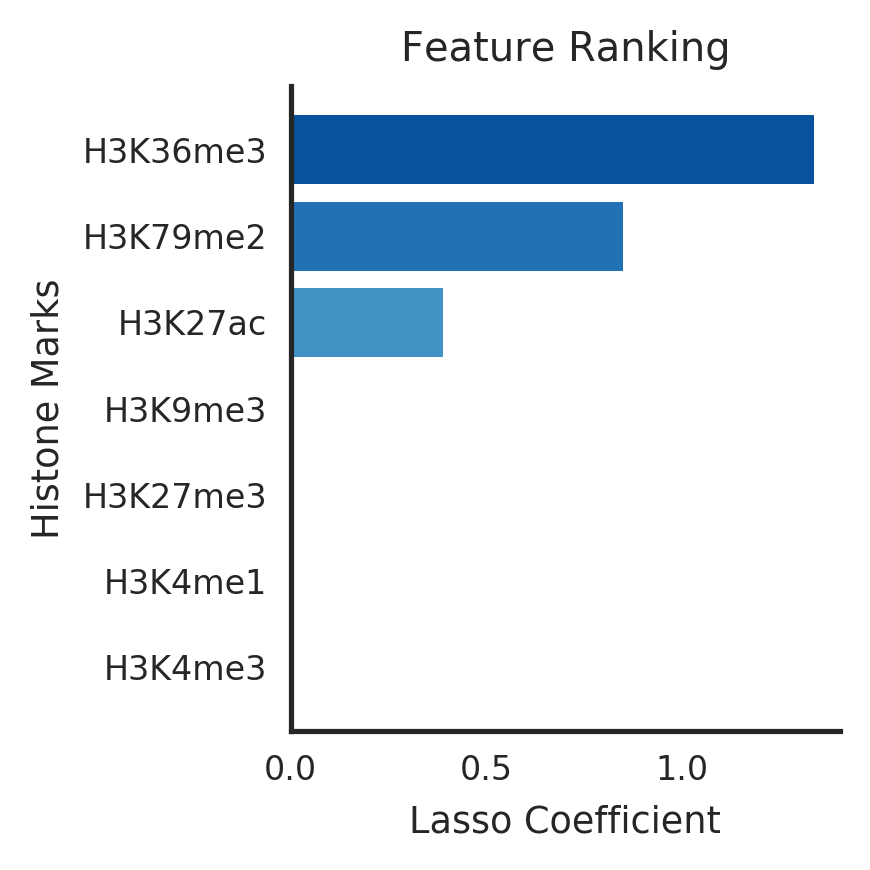

In [16]:
fig,ax = plt.subplots(dpi=300, figsize=(3,3))
ax.barh(range(7),imp_coef.values[::-1], color=sns.color_palette("Blues_r",7)[::-1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks(range(7))
ax.set_yticklabels([i.split("_")[-1] for i in imp_coef.index][::-1])
ax.set_title("Feature Ranking")
ax.set_xlabel("Lasso Coefficient")
ax.set_ylabel("Histone Marks")
plt.tight_layout()
plt.savefig("../FIGURES/Feature_ranking.pdf")

/home/ferrari/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


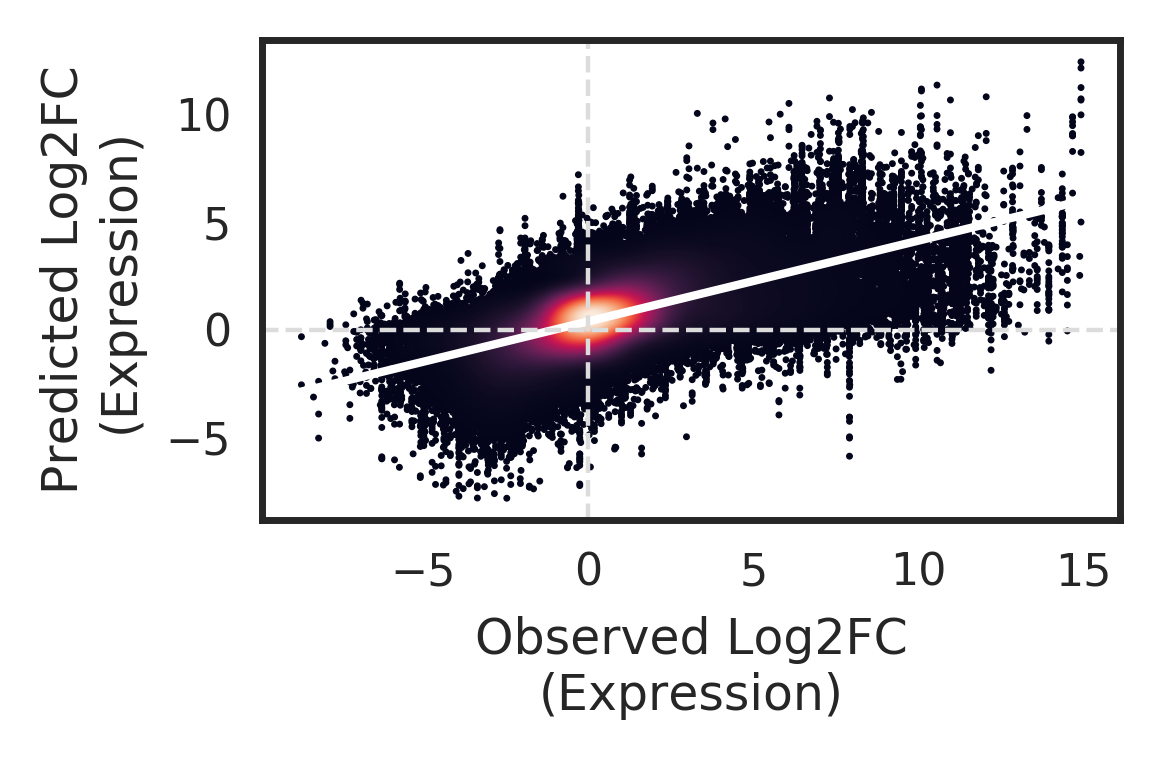

In [17]:
fig,ax = plt.subplots(dpi=400, figsize=(3,2))
rel.density_scatter(y.values,reg.predict(X),ax=ax)
ax.set_xlabel("Observed Log2FC\n(Expression)")
ax.set_ylabel("Predicted Log2FC\n(Expression)")
sns.regplot(y.values,reg.predict(X), scatter=False, color='white', line_kws={"linewidth":1.5,"linestyle":"-"}, ax=ax)

ax.axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax.axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")
plt.tight_layout()
plt.savefig("../FIGURES/observedVSpredictedLasso.pdf")
plt.savefig("../FIGURES/observedVSpredictedLasso.png")

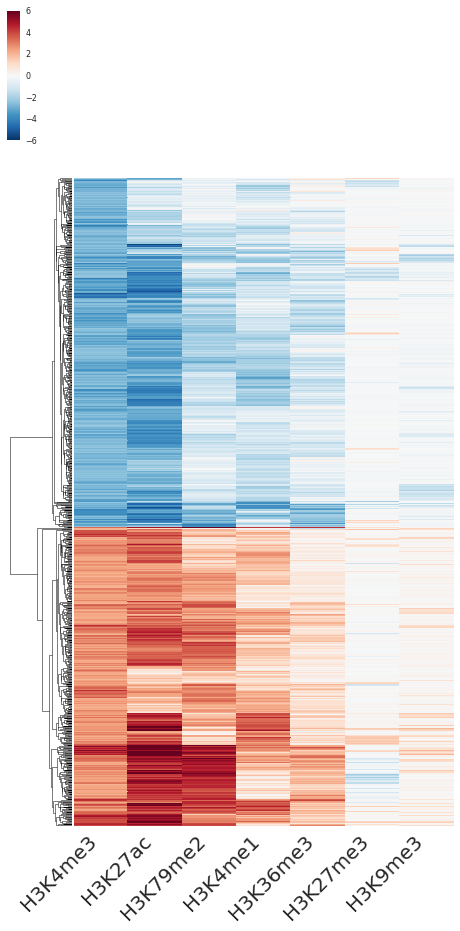

In [20]:
m_plot = m6[list(m6)[:-2]].loc[m6.index[:1000]].dropna()[["log2FoldChange_H3K4me3","log2FoldChange_H3K27ac","log2FoldChange_H3K79me2","log2FoldChange_H3K4me1","log2FoldChange_H3K36me3","log2FoldChange_H3K27me3","log2FoldChange_H3K9me3"]]
m_plot.columns = ["H3K4me3","H3K27ac","H3K79me2","H3K4me1","H3K36me3","H3K27me3","H3K9me3"]
# sns.set(font_scale=1.5)
g = sns.clustermap(m_plot, cmap="RdBu_r", center=0, col_cluster=False, yticklabels=0, vmin=-6,vmax=6, figsize=(8,15))
# g = sns.clustermap(m_plot, cmap="RdBu_r", center=0, col_cluster=False, yticklabels=0, vmin=-6,vmax=6, figsize=(8,15))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 20)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45,ha="right")
g.savefig("../FIGURES/Clustermap_topVar_loci_Epigenome.png")


In [ ]:
fig, ax = plt.subplots(3,3,dpi=400, figsize=(8,8), sharey=True, sharex=True)

rel.density_scatter(mm.log2FoldChange_H3K36me3.values, mm.log2FoldChange.values, ax=ax[0][0])
ax[0][0].set_title("H3K36me3")
ax[0][0].annotate("Pearson CC\n{}".format(round(np.corrcoef(mm.log2FoldChange_H3K36me3.values, mm.log2FoldChange.values).reshape(-1)[1],2)),(3,-5), size=7)

ax[0][0].set_xlim(-7,7)
ax[0][0].set_ylim(-12,20)
ax[0][0].axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax[0][0].axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")

rel.density_scatter(mm.log2FoldChange_H3K79me2.values, mm.log2FoldChange.values, ax=ax[0][1])
ax[0][1].set_title("H3K79me2")
ax[0][1].annotate("Pearson CC\n{}".format(round(np.corrcoef(mm.log2FoldChange_H3K79me2.values, mm.log2FoldChange.values).reshape(-1)[1],2)),(3,-5), size=7)

ax[0][1].axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax[0][1].axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")



rel.density_scatter(mm.log2FoldChange_H3K27ac.values, mm.log2FoldChange.values, ax=ax[0][2])
ax[0][2].set_title("H3K27ac")
ax[0][2].annotate("Pearson CC\n{}".format(round(np.corrcoef(mm.log2FoldChange_H3K27ac.values, mm.log2FoldChange.values).reshape(-1)[1],2)),(3,-5), size=7)

ax[0][2].axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax[0][2].axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")



rel.density_scatter(mm.log2FoldChange_H3K4me1.values, mm.log2FoldChange.values, ax=ax[1][0])
ax[1][0].set_title("H3K4me1")
ax[1][0].annotate("Pearson CC\n{}".format(round(np.corrcoef(mm.log2FoldChange_H3K4me1.values, mm.log2FoldChange.values).reshape(-1)[1],2)),(3,-5), size=7)

ax[1][0].axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax[1][0].axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")



rel.density_scatter(mm.log2FoldChange_H3K4me3.values, mm.log2FoldChange.values, ax=ax[1][1])
ax[1][1].set_title("H3K4me3")
ax[1][1].annotate("Pearson CC\n{}".format(round(np.corrcoef(mm.log2FoldChange_H3K4me3.values, mm.log2FoldChange.values).reshape(-1)[1],2)),(3,-5), size=7)

ax[1][1].axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax[1][1].axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")



rel.density_scatter(mm.log2FoldChange_H3K9me3.values, mm.log2FoldChange.values, ax=ax[2][0])
ax[2][0].set_title("H3K9me3")
ax[2][0].annotate("Pearson CC\n{}".format(round(np.corrcoef(mm.log2FoldChange_H3K9me3.values, mm.log2FoldChange.values).reshape(-1)[1],2)),(3,-5), size=7)

ax[2][0].axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax[2][0].axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")



rel.density_scatter(mm.log2FoldChange_H3K27me3.values, mm.log2FoldChange.values,ax=ax[2][1])
ax[2][1].set_title("H3K27me3")
ax[2][1].annotate("Pearson CC\n{}".format(round(np.corrcoef(mm.log2FoldChange_H3K27me3.values, mm.log2FoldChange.values).reshape(-1)[1],2)),(3,-5), size=7)

ax[2][1].axvline(0, linewidth=0.8, linestyle="--", color="gainsboro")
ax[2][1].axhline(0, linewidth=0.8, linestyle="--", color="gainsboro")


ax[1][2].axis('off')
ax[2][2].axis('off')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Log2FC Histone Mark")
plt.ylabel("Log2FC Expression")

plt.tight_layout()
plt.savefig("../FIGURES/correlation_expression_dynamicEpigenome.png")